In [69]:
!pip install -q langchain_anthropic langgraph dotenv langsmith

In [1]:
# LLM
from dotenv import load_dotenv
from langsmith import traceable
load_dotenv()

import os
from langchain_anthropic import ChatAnthropic
llm = ChatAnthropic(model="claude-3-5-sonnet-latest", anthropic_api_key=os.getenv("ANTHROPIC_API_KEY"))


In [2]:
import logging
import json

logging.basicConfig(
    filename="llm_trace.log",
    level=logging.INFO,
    format="%(asctime)s %(levelname)s: %(message)s",
)

def log_json(data, tag="log"):
    with open("trace.jsonl", "a") as f:
        f.write(json.dumps({"tag": tag, **data}) + "\n")



In [3]:
from pydantic import BaseModel, Field
from typing import Annotated, List
import operator

# Schema for structured output to use in planning
class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )


class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections of the report.",
    )

# Augment the LLM with schema for structured output
planner = llm.with_structured_output(Sections)

In [4]:
from typing_extensions import TypedDict

# Graph state
class State(TypedDict):
    topic: str  # Report topic
    sections: list[Section]  # List of report sections
    completed_sections: Annotated[
        list, operator.add
    ]  # All workers write to this key in parallel
    final_report: str  # Final report

# Worker state
class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]

In [5]:
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.constants import Send



# Nodes
def orchestrator(state: State):
    """Orchestrator that generates a plan for the report"""

    # Generate queries
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report."),
            HumanMessage(content=f"Here is the report topic: {state['topic']}"),
        ]
    )

    logging.info("Planning report with topic: %s", state["topic"])
    logging.info("Generated sections: %s", report_sections.sections)
    return {"sections": report_sections.sections}


def llm_call(state: WorkerState):
    """Worker writes a section of the report"""

    # Generate section
    section = llm.invoke(
        [
            SystemMessage(content="Write a report section."),
            HumanMessage(
                content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}"
            ),
        ]
    )

    logging.info("Writing section: %s", state["section"].name)
    logging.info("Section output: %s", section.content)
    # Write the updated section to completed sections
    return {"completed_sections": [section.content]}


def synthesizer(state: State):
    """Synthesize full report from sections"""

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)
    
    logging.info("Synthesizing report from sections")
    logging.info("Final report content: %s", completed_report_sections)
    return {"final_report": completed_report_sections}


# Conditional edge function to create llm_call workers that each write a section of the report
def assign_workers(state: State):
    """Assign a worker to each section in the plan"""

    # Kick off section writing in parallel via Send() API
    return [Send("llm_call", {"section": s}) for s in state["sections"]]

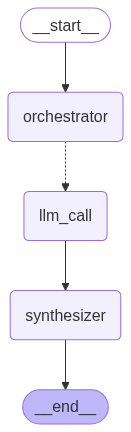

In [7]:
from langgraph.constants import Send
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

    
# Build workflow
orchestrator_worker_builder = StateGraph(State)

# Add the nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

# Add edges to connect nodes
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

# Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()

# Show the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

In [ ]:
from langchain_core.messages import HumanMessage, SystemMessage


state = orchestrator_worker.invoke({"topic": "3 step guide how to win at league of legends"})



from IPython.display import Markdown

Markdown(state["final_report"])

Here's a draft of that section:

Master the Fundamentals

Success in League of Legends is built upon a foundation of fundamental skills that every player must develop and consistently execute. While flashy plays may be exciting, it's the mastery of basic mechanics that truly separates good players from great ones.

Last Hitting and CS
Maintaining a strong creep score (CS) through effective last hitting is arguably the most important fundamental skill to master. Each minion kill provides gold, and missing these crucial last hits can significantly impact your ability to purchase items and scale into the late game. Aim to achieve at least 70-80 CS by the 10-minute mark through regular practice. Remember that a perfect CS score of 100 at 10 minutes is possible, giving you something to strive toward.

Map Awareness
Developing strong map awareness helps prevent ganks and identifies opportunities across the map. Make it a habit to glance at your minimap every few seconds. Watch for enemy movement patterns, missing laners, and potential objective plays. Understanding where enemies might be, even when you can't see them, is crucial for making informed decisions during the game.

Vision Control
Proper warding is essential for team success and individual survival. Learn the key warding spots that provide maximum vision coverage:
- River entrances to prevent ganks
- Objective areas (Dragon and Baron)
- Enemy jungle entrances to track the opposing jungler
- Deep wards when pushing lanes

Remember to purchase and use control wards, and help your team clear enemy vision when possible. Vision control isn't just the support's responsibility – it's a team effort that wins games.

Practice Makes Perfect
These fundamentals require consistent practice to master. Consider the following training routine:
1. Practice last hitting in custom games without items
2. Set a timer to remind yourself to check the minimap
3. Review your ward placement after games to identify improvement areas

Remember that even professional players continue to work on these basics. Strong fundamentals provide the platform upon which all other aspects of your gameplay can build. By mastering these essential skills, you'll create a solid foundation for climbing the ranked ladder and improving your overall performance.

---

Here's a draft of that section:

Strategic Decision Making

Success in competitive gaming requires making countless strategic decisions throughout each match. This section explores the critical elements that should inform your decision-making process and help you consistently make optimal choices.

Objective Control
A fundamental aspect of strategic play is maintaining control over key objectives. This means:
- Prioritizing objectives based on their strategic value and timing
- Coordinating with your team to secure vision and map control around important objectives
- Understanding when to trade objectives versus contest them
- Recognizing which objectives will help snowball your advantage

Team Composition Analysis
Every team composition has distinct strengths and win conditions. To make good decisions, you must:
- Identify your team's primary win conditions and optimal fighting style
- Understand power spikes related to key items and ability levels
- Recognize favorable and unfavorable matchups
- Adapt your strategy based on both team compositions

Positioning and Teamfight Execution
Proper positioning is crucial for both individual survival and team success:
- Position yourself to maximize your impact while minimizing risk
- Maintain awareness of key enemy threats and cooldowns
- Control space to protect high-priority teammates
- Create and exploit positional advantages through map pressure

Resource Management
Knowing when to fight versus farm is a critical skill:
- Evaluate risk vs reward for potential engagements
- Recognize safe farming opportunities between objectives
- Balance personal farm with team needs
- Maintain tempo advantage through efficient resource collection

Capitalizing on Advantages
When ahead, it's essential to:
- Apply constant pressure without overextending
- Deny enemy resources and vision
- Systematically take control of larger portions of the map
- Close out games before the enemy can scale

When behind, focus on:
- Identifying comeback opportunities
- Maximizing available resources
- Trading objectives efficiently
- Avoiding unfavorable engagements

By mastering these strategic elements, players can make better decisions throughout the game. Remember that good strategy requires both understanding these concepts and practicing their application in real game situations. Review your decisions after each match to identify areas for improvement and gradually refine your strategic thinking.

---

Here's a draft of the Mental Game and Advanced Tactics section:

Mental Game and Advanced Tactics

Success in competitive gaming isn't just about mechanical skill – the mental aspect and strategic depth play crucial roles in achieving consistent results. This section explores both the psychological elements and advanced gameplay concepts that can elevate your performance.

Maintaining Mental Fortitude

1. Positive Mindset
- Focus on improvement rather than just winning
- Celebrate small victories and progress
- Practice positive self-talk during matches
- Set realistic, achievable goals for each gaming session

2. Dealing with Tilt
- Recognize early signs of frustration
- Take regular breaks between intense matches
- Develop a personal reset routine
- Learn to mute toxic players and focus on your gameplay
- Use defeats as learning opportunities

3. Stress Management
- Practice deep breathing exercises
- Maintain good physical health through exercise and proper rest
- Establish pre-game routines to center yourself
- Keep hydrated and take short breaks between matches

Advanced Gameplay Concepts

1. Wave Management
- Understanding minion wave dynamics
- Freezing lanes strategically
- Creating slow pushes
- Timing recall windows effectively
- Manipulating waves for objective control

2. Macro Strategy
- Objective prioritization
- Map pressure and rotation timing
- Split-pushing opportunities
- Vision control and map awareness
- Resource allocation across the map

3. Team Coordination
- Shot calling and decision making
- Understanding team compositions
- Role flexibility and adaptation
- Communication efficiency
- Objective setup and execution

Learning and Improvement

1. Replay Analysis
- Review your gameplay regularly
- Identify decision-making patterns
- Study professional players' perspectives
- Track improvement areas systematically

2. Mistake Recognition
- Maintain a gameplay journal
- Document recurring errors
- Develop specific solutions for common mistakes
- Create practice routines targeting weak areas

3. Advanced Strategy Implementation
- Start with basic concepts and gradually increase complexity
- Practice new strategies in normal games before ranked
- Seek feedback from higher-ranked players
- Join communities focused on improvement

Building these mental and strategic foundations will help you maintain consistency in your gameplay and continue progressing even during challenging periods. Remember that improvement is a journey, not a destination, and maintaining a growth mindset while implementing advanced tactics will lead to long-term success.

Key Takeaways:
- Mental stability is as important as mechanical skill
- Advanced tactics require patience and systematic practice
- Continuous learning and adaptation are essential
- Team coordination enhances individual performance
- Regular self-analysis leads to consistent improvement